In [17]:
import pandas as pd
from trader import Trader
from datamodel import *
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv("8cf4dead-dd7a-4882-8510-bbce815a8c28.csv",sep = ";")

In [19]:
data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.000000
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,31,NaN,NaN,NaN,NaN,2028.5,0.000000
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,2,2029.0,22.0,NaN,NaN,2026.5,1.157471
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,2.000000
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,-6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1,199700,KELP,2020,27,NaN,NaN,NaN,NaN,2023,2,2024.0,25.0,NaN,NaN,2021.5,470.531250
3996,-1,199800,RAINFOREST_RESIN,9995,21,NaN,NaN,NaN,NaN,10002,8,10005.0,21.0,NaN,NaN,9998.5,-180.000000
3997,-1,199800,KELP,2020,21,NaN,NaN,NaN,NaN,2023,21,NaN,NaN,NaN,NaN,2021.5,472.593750
3998,-1,199900,KELP,2020,32,NaN,NaN,NaN,NaN,2022,7,2023.0,2.0,2024.0,30.0,2021.0,468.351562


In [20]:
rainforest_market_data = data[data["product"] == "RAINFOREST_RESIN"]
kelp_market_data = data[data["product"] == "KELP"]	


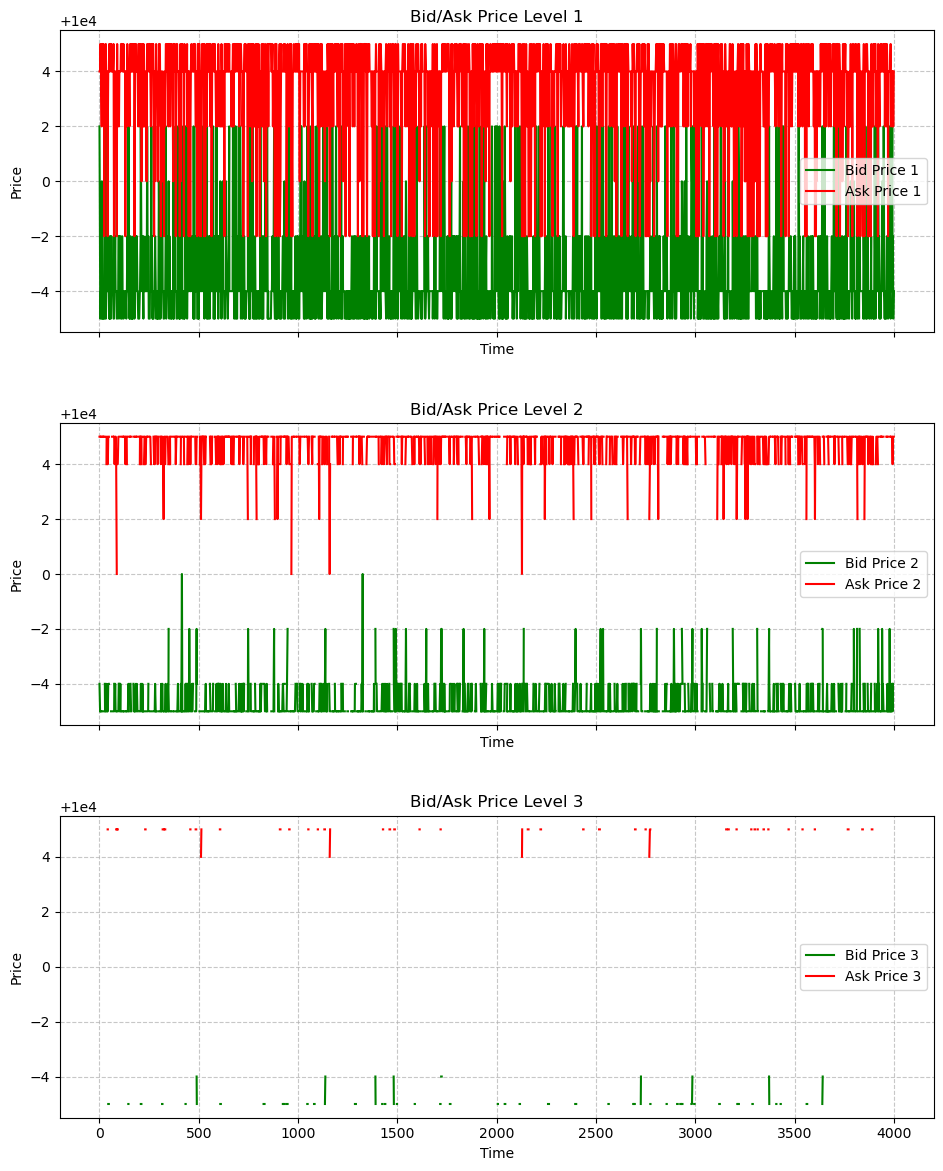

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
plt.tight_layout(pad=3.0)

for i in range(1, 4):
    ax = axes[i-1]
    ax.set_title(f"Bid/Ask Price Level {i}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    
    # Plot bid and ask prices with different colors and labels
    bid_line, = ax.plot(rainforest_market_data[f"bid_price_{i}"], color='green', label=f'Bid Price {i}')
    ask_line, = ax.plot(rainforest_market_data[f"ask_price_{i}"], color='red', label=f'Ask Price {i}')
    
    # Add spread as shaded area
    #ax.fill_between(rainforest_market_data.index, 
    #                rainforest_market_data[f"bid_price_{i}"], 
    #                rainforest_market_data[f"ask_price_{i}"], 
    #                color='gray', alpha=0.2)
    
    # Add legend
    ax.legend(loc='best')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

#plt.suptitle("RAINFOREST_RESIN Market Data", fontsize=16)
plt.subplots_adjust(hspace=0.3)


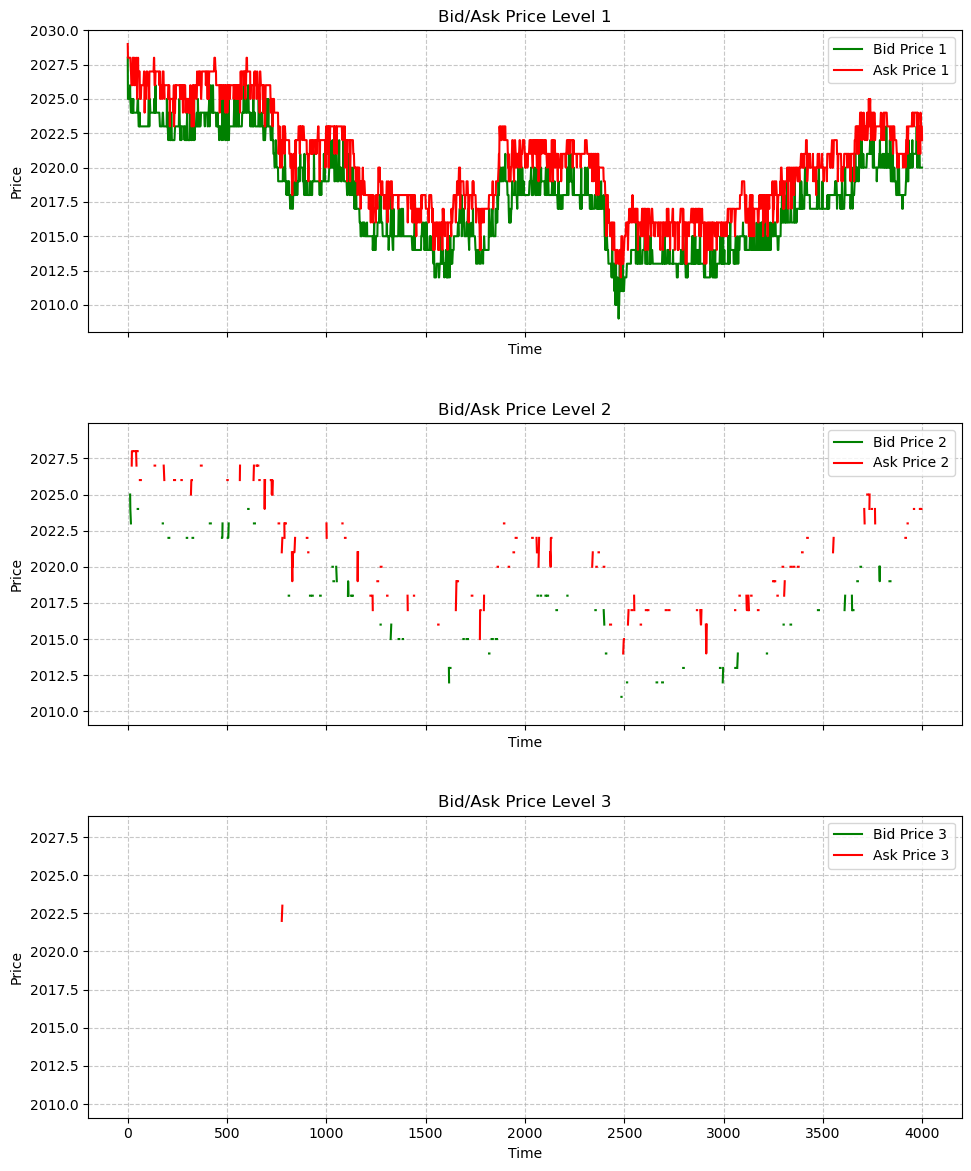

In [22]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
plt.tight_layout(pad=3.0)

for i in range(1, 4):
    ax = axes[i-1]
    ax.set_title(f"Bid/Ask Price Level {i}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    
    # Plot bid and ask prices with different colors and labels
    bid_line, = ax.plot(kelp_market_data[f"bid_price_{i}"], color='green', label=f'Bid Price {i}')
    ask_line, = ax.plot(kelp_market_data[f"ask_price_{i}"], color='red', label=f'Ask Price {i}')
    
    # Add legend
    ax.legend(loc='best')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

plt.subplots_adjust(hspace=0.3)


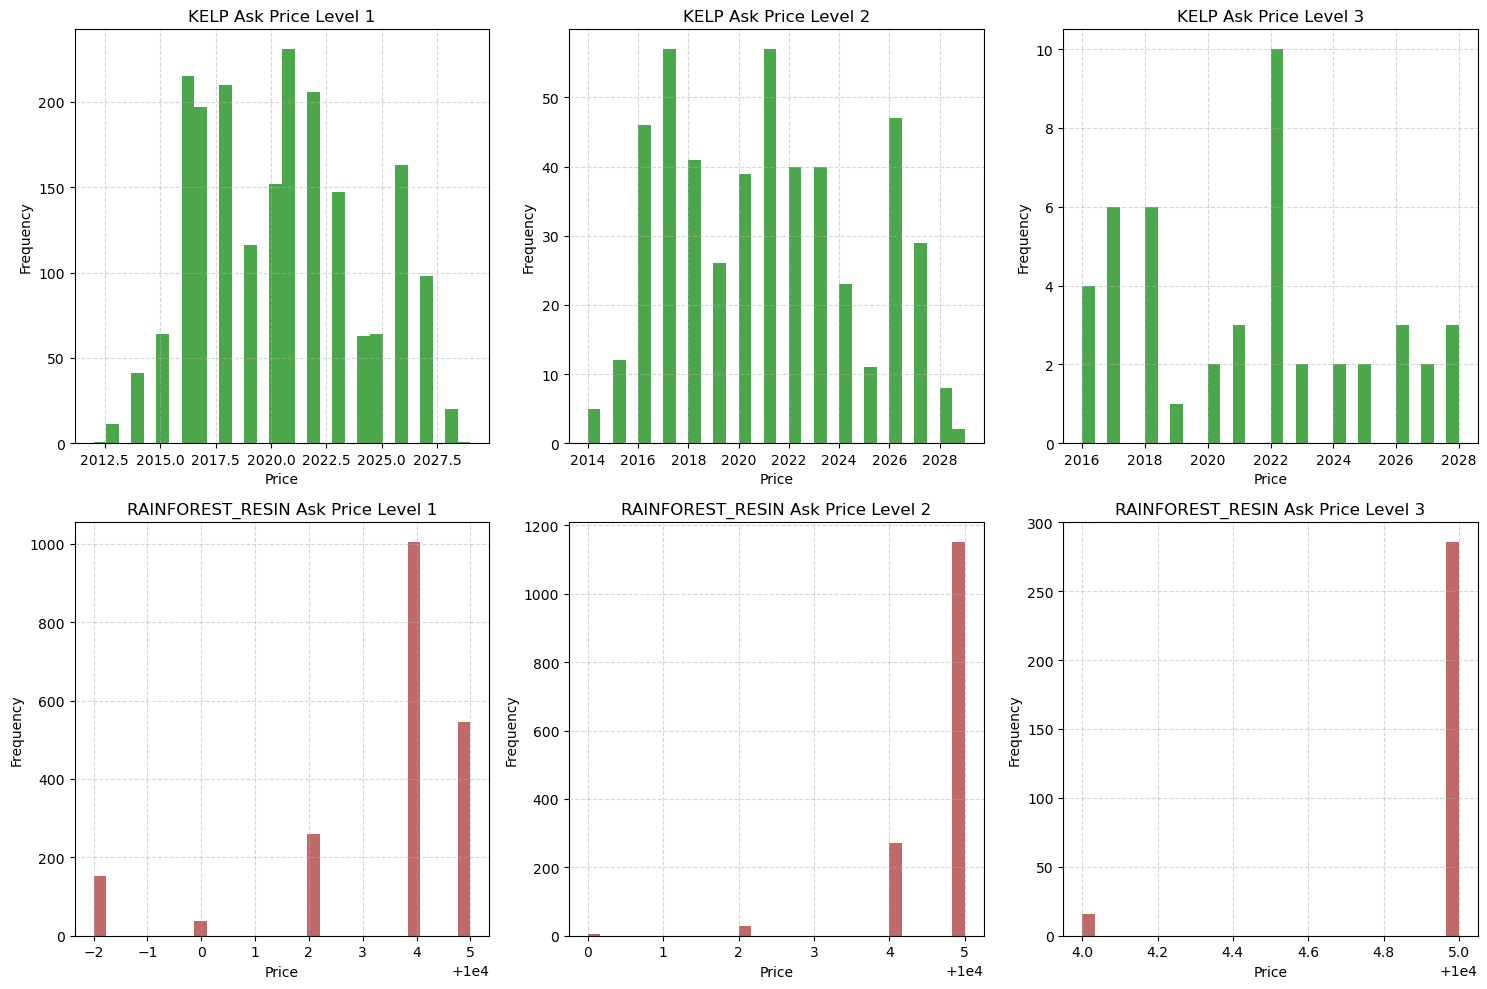

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row - KELP data
for i in range(3):
    axes[0, i].hist(kelp_market_data[f"ask_price_{i+1}"], bins=30, color='green', alpha=0.7)
    axes[0, i].set_title(f"KELP Ask Price Level {i+1}")
    axes[0, i].set_xlabel("Price")
    axes[0, i].set_ylabel("Frequency")
    axes[0, i].grid(True, linestyle='--', alpha=0.5)

# Second row - RAINFOREST_RESIN data
for i in range(3):
    axes[1, i].hist(rainforest_market_data[f"ask_price_{i+1}"], bins=30, color='brown', alpha=0.7)
    axes[1, i].set_title(f"RAINFOREST_RESIN Ask Price Level {i+1}")
    axes[1, i].set_xlabel("Price")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

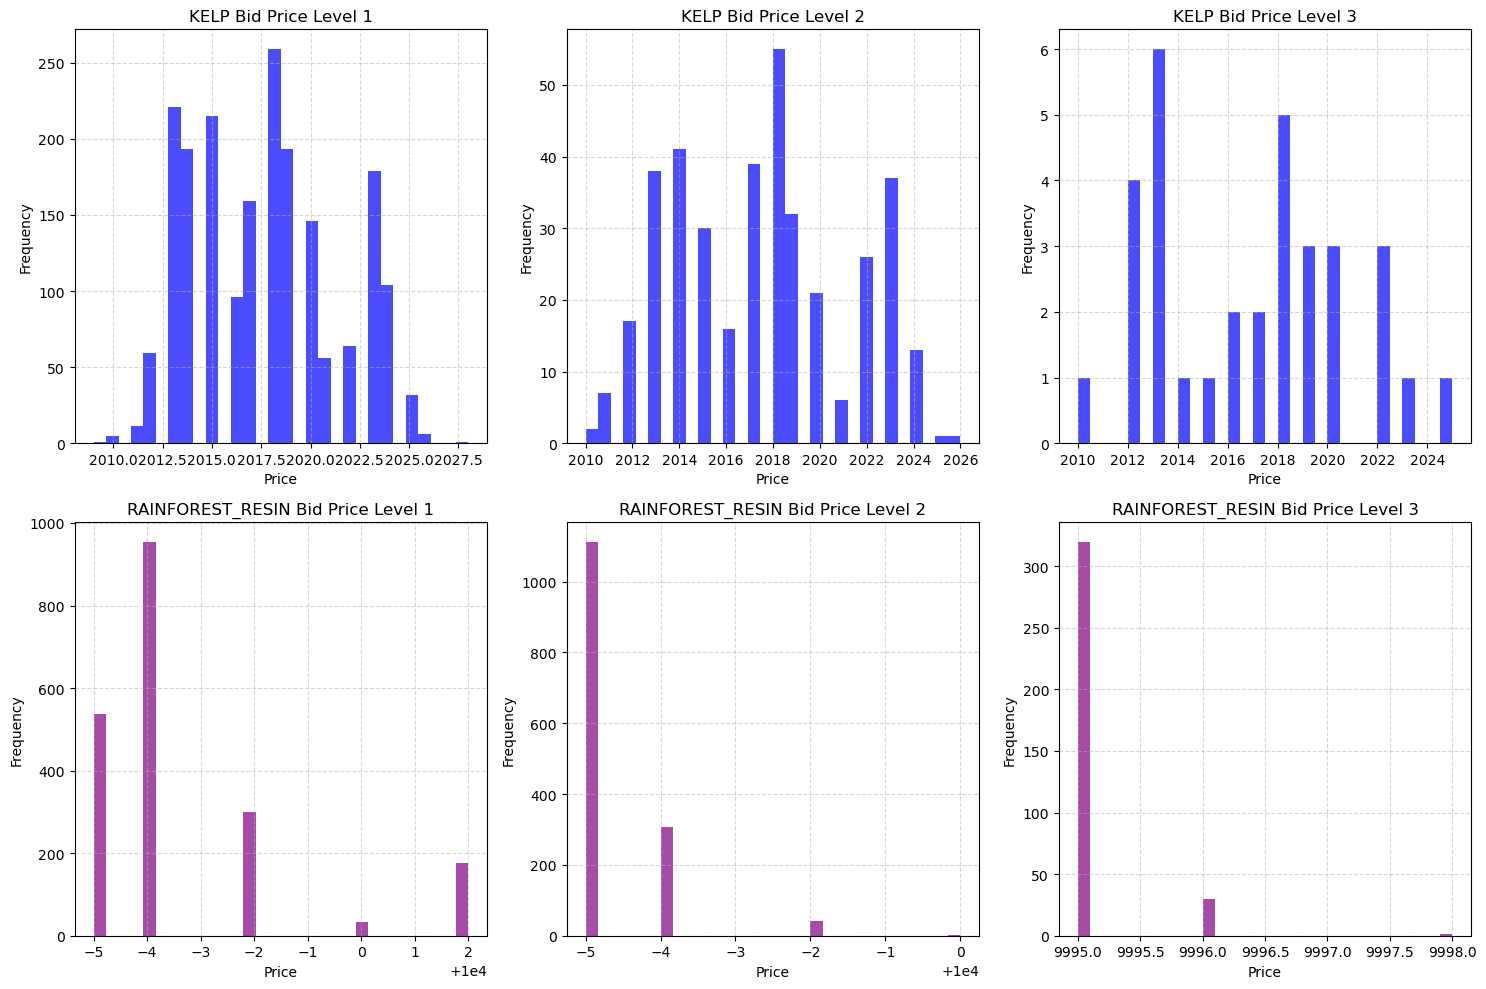

In [24]:
# Create a figure with 2 rows and 3 columns for bid price histograms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# First row - KELP bid data
for i in range(3):
    axes[0, i].hist(kelp_market_data[f"bid_price_{i+1}"], bins=30, color='blue', alpha=0.7)
    axes[0, i].set_title(f"KELP Bid Price Level {i+1}")
    axes[0, i].set_xlabel("Price")
    axes[0, i].set_ylabel("Frequency")
    axes[0, i].grid(True, linestyle='--', alpha=0.5)

# Second row - RAINFOREST_RESIN bid data
for i in range(3):
    axes[1, i].hist(rainforest_market_data[f"bid_price_{i+1}"], bins=30, color='purple', alpha=0.7)
    axes[1, i].set_title(f"RAINFOREST_RESIN Bid Price Level {i+1}")
    axes[1, i].set_xlabel("Price")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()


The Basic Strategy  we have is:

1. For RAINFOREST_RESIN if product_price > 0 sell if <0 Buy
2. For KELP if product_price > 2015 sell if <2015 Buy

In [25]:
fair_prices = [0,2015]

for index,row in data.iterrows():
    timestamp: Time = row["timestamp"]
    product: Product = row["product"]
    symbol: Symbol = Symbol(product)
    traderData = "Dragonera"
    bids: Dict = {row[f"bid_price_{i}"]: row[f"bid_volume_{i}"] for i in range(1, 4) if pd.notna(row[f'bid_price_{i}'])}
    asks: Dict = {row[f"ask_price_{i}"]: row[f"ask_volume_{i}"] for i in range(1, 4) if pd.notna(row[f'ask_price_{i}'])}
    order_depth = OrderDepth()
    order_depth.buy_orders = bids
    order_depth.sell_orders = asks
    order_depths = {symbol: order_depth}
    own_trades = [symbol, List[Trade(None,None,None)]]
    market_trades = [symbol, List[Trade(None, None, None)]] #I think we will not be interested in this but we need to initialize it
    pos: Position = 0
    position: Dict= {product:  pos}
    listings: Dict[Symbol, Listing] = {symbol: Listing(symbol=symbol,product=product,denomination=product)}  # Assuming fair price is in the data
    best_bid = max(bids.keys(), default=None)
    best_ask = min(asks.keys(), default=None)
    mid_price = (best_bid + best_ask) / 2 if best_bid is not None and best_ask is not None else None
    transportfee = 0
    exporttarif = 0
    importtarif = 0
    sugarprice = 0
    sunlightindex = 0
    plain_value_obss: Dict[Product,ObservationValue] = {product:mid_price}
    conv_obs = ConversionObservation(bidPrice=best_bid,askPrice=best_ask,
                                        transportFees=transportfee,
                                        exportTariff=exporttarif,
                                        importTariff=importtarif,
                                        sugarPrice=sugarprice,
                                        sunlightIndex=sunlightindex)
    conversion_obss: Dict[Product, ConversionObservation] = {product: conv_obs}
    observation: Observation = Observation(conversionObservations=conversion_obss,
                                           plainValueObservations=plain_value_obss)
    state = TradingState(traderData= traderData,
                         timestamp=timestamp,
                         order_depths=order_depths,
                         own_trades=own_trades,
                         market_trades=market_trades,
                         position=position,
                         observations= observation,
                         listings=listings)
    trader = Trader()
    trader.run(state)

traderData: Dragonera
Observations: (plainValueObservations: {"RAINFOREST_RESIN": 10003.0}, conversionObservations: {"RAINFOREST_RESIN": {"py/object": "datamodel.ConversionObservation", "bidPrice": 10002, "askPrice": 10004, "transportFees": 0, "exportTariff": 0, "importTariff": 0, "sugarPrice": 0, "sunlightIndex": 0}})
Buy Order depth : 3, Sell order depth : 2
SELL 1x 10002
traderData: Dragonera
Observations: (plainValueObservations: {"KELP": 2028.5}, conversionObservations: {"KELP": {"py/object": "datamodel.ConversionObservation", "bidPrice": 2028, "askPrice": 2029, "transportFees": 0, "exportTariff": 0, "importTariff": 0, "sugarPrice": 0, "sunlightIndex": 0}})
Buy Order depth : 3, Sell order depth : 1
SELL 1x 2028
traderData: Dragonera
Observations: (plainValueObservations: {"KELP": 2026.5}, conversionObservations: {"KELP": {"py/object": "datamodel.ConversionObservation", "bidPrice": 2025, "askPrice": 2028, "transportFees": 0, "exportTariff": 0, "importTariff": 0, "sugarPrice": 0, "s

In [26]:
import pandas as pd
from datamodel import OrderDepth, TradingState, Order, Listing, Observation, ConversionObservation
from collections import defaultdict

def backtest_trader(data, Trader, position_limits=None):
    """
    Simplified backtest with position limits and competitive order execution
    """
    # Default position limits
    if position_limits is None:
        position_limits = {'KELP': 50, 'RAINFOREST_RESIN': 50}
    
    # Initialize trader
    trader = Trader()
    
    # Track state
    positions = defaultdict(int)
    cash = 0
    pnl_history = []
    trades_history = []
    
    # Trader state
    trader_data = "SAMPLE"
    
    # Group data by timestamp
    grouped_data = data.groupby(['timestamp'])
    
    for timestamp, group in grouped_data:
        # Initialize state components
        order_depths = {}
        position = {}
        listings = {}
        
        # Process each product
        for _, row in group.iterrows():
            product = row["product"]
            symbol = product
            
            # Build OrderDepth
            bids = {row[f"bid_price_{i}"]: row[f"bid_volume_{i}"] for i in range(1, 4) if pd.notna(row[f'bid_price_{i}'])}
            asks = {row[f"ask_price_{i}"]: row[f"ask_volume_{i}"] for i in range(1, 4) if pd.notna(row[f'ask_price_{i}'])}
            
            order_depth = OrderDepth()
            order_depth.buy_orders = bids
            order_depth.sell_orders = asks
            order_depths[symbol] = order_depth
            
            # Set position
            position[product] = positions[product]
            
            # Create listing
            listings[symbol] = Listing(symbol=symbol, product=product, denomination=product)
        
        # Create simplified observations
        observation = Observation(
            plainValueObservations={},
            conversionObservations={p: ConversionObservation(0, 0, 0, 0, 0, 0, 0) for p in position.keys()}
        )
        
        # Create state
        state = TradingState(
            traderData=trader_data,
            timestamp=timestamp,
            order_depths=order_depths,
            own_trades={},
            market_trades={},
            position=position,
            observations=observation,
            listings=listings
        )
        
        # Run trader
        result, _, trader_data = trader.run(state)
        
        # Process orders
        for product, orders in result.items():
            # Get the best bid and ask from the market
            best_bid = max(order_depths[product].buy_orders.keys()) if order_depths[product].buy_orders else -float('inf')
            best_ask = min(order_depths[product].sell_orders.keys()) if order_depths[product].sell_orders else float('inf')
            
            for order in orders:
                price = order.price
                quantity = order.quantity
                
                # Check position limits
                new_position = positions[product] + quantity
                if abs(new_position) > position_limits.get(product, float('inf')):
                    print(f"Rejected: {quantity} {product} @ {price} - Would exceed position limit")
                    continue
                
                # For buys (quantity > 0)
                if quantity > 0:
                    # Only execute if our price is at least as good as the best ask
                    if price >= best_ask and price in order_depths[product].sell_orders:
                        available = order_depths[product].sell_orders[price]
                        filled = min(quantity, available)
                        
                        # Execute trade
                        positions[product] += filled
                        cash -= price * filled
                        
                        # Record trade
                        trades_history.append({
                            'timestamp': timestamp,
                            'product': product,
                            'price': price,
                            'quantity': filled,
                            'side': 'BUY'
                        })
                        print(f"Executed BUY: {filled} {product} @ {price}")
                
                # For sells (quantity < 0)
                elif quantity < 0:
                    abs_quantity = abs(quantity)
                    # Only execute if our price is at least as good as the best bid
                    if price <= best_bid and price in order_depths[product].buy_orders:
                        available = order_depths[product].buy_orders[price]
                        filled = min(abs_quantity, available)
                        
                        # Execute trade
                        positions[product] -= filled
                        cash += price * filled
                        
                        # Record trade
                        trades_history.append({
                            'timestamp': timestamp,
                            'product': product,
                            'price': price,
                            'quantity': filled,
                            'side': 'SELL'
                        })
                        print(f"Executed SELL: {filled} {product} @ {price}")
        
        # Calculate simple PnL
        position_value = 0
        for product, pos in positions.items():
            # Use mid price for position valuation
            product_row = group[group['product'] == product]
            if not product_row.empty:
                # Try to use mid_price column if available
                if 'mid_price' in product_row.columns and not pd.isna(product_row['mid_price'].iloc[0]):
                    mid_price = product_row['mid_price'].iloc[0]
                else:
                    # Calculate from bid/ask
                    bid = product_row['bid_price_1'].iloc[0] if not pd.isna(product_row['bid_price_1'].iloc[0]) else 0
                    ask = product_row['ask_price_1'].iloc[0] if not pd.isna(product_row['ask_price_1'].iloc[0]) else 0
                    mid_price = (bid + ask) / 2 if bid != 0 or ask != 0 else 0
                
                position_value += pos * mid_price
        
        # Record PnL
        total_pnl = cash + position_value
        pnl_history.append({
            'timestamp': timestamp,
            'cash': cash,
            'position_value': position_value,
            'total_pnl': total_pnl
        })
    
    # Create result dataframes
    pnl_df = pd.DataFrame(pnl_history)
    trades_df = pd.DataFrame(trades_history)
    
    return {
        'pnl': pnl_df,
        'trades': trades_df,
        'final_positions': dict(positions),
        'final_pnl': pnl_df['total_pnl'].iloc[-1] if not pnl_df.empty else 0
    }

# Function to run backtest and visualize results
def run_backtest():
    results = backtest_trader(data, Trader)
    
    print(f"\nFinal PnL: {results['final_pnl']}")
    print(f"Final Positions: {results['final_positions']}")
    
    # Plot PnL
    """import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(results['pnl']['timestamp'], results['pnl']['total_pnl'])
    plt.title('Trading PnL')
    plt.xlabel('Timestamp')
    plt.ylabel('PnL')
    plt.grid(True)
    plt.show()"""
    
    return results

In [27]:
import io
def _process_data_(file):
    with open(file, 'r') as file:
        log_content = file.read()
    sections = log_content.split('Sandbox logs:')[1].split('Activities log:')
    sandbox_log =  sections[0].strip()
    activities_log = sections[1].split('Trade History:')[0]
    # sandbox_log_list = [json.loads(line) for line in sandbox_log.split('\n')]
    trade_history =  json.loads(sections[1].split('Trade History:')[1])
    # sandbox_log_df = pd.DataFrame(sandbox_log_list)
    market_data_df = pd.read_csv(io.StringIO(activities_log), sep=";", header=0)
    trade_history_df = pd.json_normalize(trade_history)
    return market_data_df, trade_history_df

In [28]:
market_data, trade_history = _process_data_("94c5bd59-6268-43e3-b99a-3b5abc114c78.log")

In [29]:
market_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,RAINFOREST_RESIN,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.000000
1,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,31,NaN,NaN,NaN,NaN,2028.5,0.000000
2,-1,100,KELP,2025,24,NaN,NaN,NaN,NaN,2028,2,2029.0,22.0,NaN,NaN,2026.5,1.157471
3,-1,100,RAINFOREST_RESIN,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,2.000000
4,-1,200,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,-6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1,199700,KELP,2020,27,NaN,NaN,NaN,NaN,2023,2,2024.0,25.0,NaN,NaN,2021.5,162.531250
3996,-1,199800,RAINFOREST_RESIN,9995,21,NaN,NaN,NaN,NaN,10002,8,10005.0,21.0,NaN,NaN,9998.5,-180.000000
3997,-1,199800,KELP,2020,21,NaN,NaN,NaN,NaN,2023,21,NaN,NaN,NaN,NaN,2021.5,164.593750
3998,-1,199900,KELP,2020,32,NaN,NaN,NaN,NaN,2022,7,2023.0,2.0,2024.0,30.0,2021.0,160.351562


In [30]:
trade_history

,timestamp,buyer,seller,symbol,currency,price,quantity
0,0,,SUBMISSION,KELP,SEASHELLS,2028,1
1,0,,SUBMISSION,RAINFOREST_RESIN,SEASHELLS,10002,1
2,0,,,KELP,SEASHELLS,2029,13
3,0,,,KELP,SEASHELLS,2029,1
4,0,,,RAINFOREST_RESIN,SEASHELLS,10004,1
...,...,...,...,...,...,...,...
1107,199400,,,RAINFOREST_RESIN,SEASHELLS,10004,1
1108,199500,,,RAINFOREST_RESIN,SEASHELLS,10002,1
1109,199600,,,KELP,SEASHELLS,2023,1
1110,199600,,,KELP,SEASHELLS,2023,1


In [32]:
results = run_backtest()

traderData: SAMPLE
Observations: (plainValueObservations: {}, conversionObservations: {"RAINFOREST_RESIN": {"py/object": "datamodel.ConversionObservation", "bidPrice": 0, "askPrice": 0, "transportFees": 0, "exportTariff": 0, "importTariff": 0, "sugarPrice": 0, "sunlightIndex": 0}, "KELP": {"py/object": "datamodel.ConversionObservation", "bidPrice": 0, "askPrice": 0, "transportFees": 0, "exportTariff": 0, "importTariff": 0, "sugarPrice": 0, "sunlightIndex": 0}})
Buy Order depth : 3, Sell order depth : 2
SELL 1x 10002
Buy Order depth : 3, Sell order depth : 1
SELL 1x 2028
Executed SELL: 1 RAINFOREST_RESIN @ 10002
Executed SELL: 1 KELP @ 2028
traderData: SAMPLE
Observations: (plainValueObservations: {}, conversionObservations: {"KELP": {"py/object": "datamodel.ConversionObservation", "bidPrice": 0, "askPrice": 0, "transportFees": 0, "exportTariff": 0, "importTariff": 0, "sugarPrice": 0, "sunlightIndex": 0}, "RAINFOREST_RESIN": {"py/object": "datamodel.ConversionObservation", "bidPrice": 0

In [33]:
pnl = results["pnl"]

In [37]:
pnl_list = list(pnl["total_pnl"].iloc[::5])

In [38]:
pnl_list[-1]

-178.0

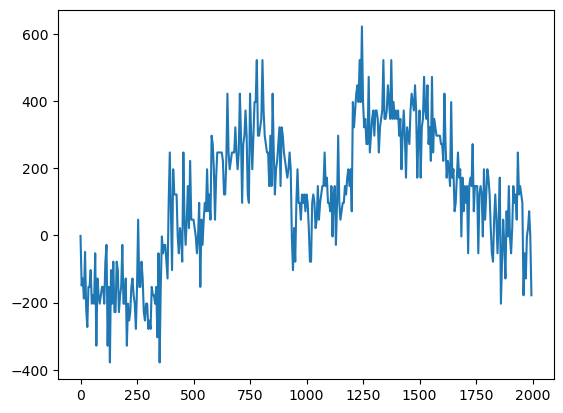

In [35]:
plt.plot(pnl_list)

In [33]:
results

{'pnl':       timestamp      cash  position_value  total_pnl
 0          (0,)  384654.0       -385008.0     -354.0
 1        (100,)  404646.0       -404848.0     -202.0
 2        (200,)  404646.0       -404848.0     -202.0
 3        (300,)  424638.0       -424848.0     -210.0
 4        (400,)  444630.0       -444848.0     -218.0
 ...         ...       ...             ...        ...
 1995  (199500,)  601062.0       -601250.0     -188.0
 1996  (199600,)  601062.0       -601025.0       37.0
 1997  (199700,)  601062.0       -601125.0      -63.0
 1998  (199800,)  601062.0       -601000.0       62.0
 1999  (199900,)  601062.0       -601050.0       12.0
 
 [2000 rows x 4 columns],
 'trades':    timestamp           product    price  quantity  side
 0       (0,)  RAINFOREST_RESIN  10002.0       1.0  SELL
 1       (0,)  RAINFOREST_RESIN   9996.0       2.0  SELL
 2       (0,)  RAINFOREST_RESIN   9995.0      29.0  SELL
 3       (0,)              KELP   2028.0       1.0  SELL
 4       (0,)         